In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ext = 'drive/MyDrive/CV_Images/'#concentric.mat'

In [ ]:
! pip install imagehash

In [ ]:
!pip install tensorflow-addons

# Install Libraries

In [ ]:
import cv2
import numpy as np
import json
import os
import random
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import seaborn as sns
import shutil
from PIL import Image
import imagehash
from matplotlib import image
from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from keras.applications.vgg16 import preprocess_input

In [ ]:
path = '/content/drive/MyDrive/CV_Images'

# Data Loader

In [ ]:
def data_loader(path, data_name, img_size): # data_name = 'cropped_train', # img_size = 128 
  all_images,img_files = [],[]

  #{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
  all_files = ['1040','1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018']#,'1021'] # ['1015','1019'] # for now manually changed as issue in 1021, 1040 #'1004', '1005','1019',
  for label_folder in all_files:
    inside_path = path+'/'+ label_folder +'/'+ data_name
    fold = os.listdir(inside_path)
    for img in fold:
      ext = os.path.splitext(img)[-1]
      if ext in ['.jpg', '.JPG']: # only jpg files no json files
        try:
          img_arr = cv2.imread(os.path.join(inside_path, img))
          #print(img_arr.shape)
          new_arr = cv2.resize(img_arr, (img_size, img_size)) 
          all_images.append([new_arr, label_folder])  
          img_files.append([img,label_folder])
        except:
          pass 
    #print(label_folder,data_name,len(all_images))
    #shuffled = list(zip(all_images, img_files))
    indices = np.arange(len(all_images))
    #print(indices)
    random.shuffle(indices)
    #print(indices)
    #print(all_images[0])
    all_images_n = [all_images[i] for i in indices]
    img_files_n = [img_files[i] for i in indices]
    #all_images = all_images[indices]
    #img_files = img_files[indices]
    #random.shuffle(all_images)
    #all_images, img_files = zip(*shuffled)
  return all_images_n,img_files_n


# rename cropped_train to folder name which you want to run
img_train,img_train_files = data_loader(path, 'train', 224)
img_test_cr,img_test_cr_files = data_loader(path, 'cropped_test', 224)
img_test_uncr,img_test_uncr_files = data_loader(path, 'uncropped_test', 224)

In [ ]:
label_dict = {'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7,'1001':8,'1007':9,'1018':10}#, '1021':5} # add the label in the dictionary #'1004':0, '1005':1, 
classes  = 11#8#7 #6 #5 #2 # 4
def preprocesing(data, num_class):
  X, y = [], []
  for features, label in data:
    X.append(features)                 
    y.append(label)  
  X = np.array(X).reshape(-1, 224, 224, 3)
  encoding =np.vectorize(label_dict.get)(y) # label encoding
  y = np.array(encoding)
  y = tf.keras.utils.to_categorical(y, num_classes=num_class) # one hot encoding
  print("The shape of the dataset:", X.shape)
  print("The shape of the label dataset:", y.shape)
  #X = X/255
  return X, y

X_train, y_train = preprocesing(img_train,classes)
X_test_cr, y_test_cr = preprocesing(img_test_cr,classes)
X_test_uncr, y_test_uncr = preprocesing(img_test_uncr,classes)

The shape of the dataset: (879, 224, 224, 3)
The shape of the label dataset: (879, 11)
The shape of the dataset: (326, 224, 224, 3)
The shape of the label dataset: (326, 11)
The shape of the dataset: (326, 224, 224, 3)
The shape of the label dataset: (326, 11)


# Preprocessing the data

In [ ]:
X_train = preprocess_input(X_train)
X_test_cr = preprocess_input(X_test_cr)
X_test_uncr = preprocess_input(X_test_uncr)

# Set Seed value

In [ ]:
seed_value = 26042022
tf.random.set_seed(seed_value)

# Double checking the values 

In [ ]:
#label_dict = {'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
l = []
for i in range(y_train.shape[1]):
  a = sum(y_train[:,i])
  l.append(a)
print(l)

for i in l:
  b = i/sum(l)
  print(b*100)

m = []
for i in range(y_train.shape[1]):
  a = sum(y_test_cr[:,i])
  m.append(a)
print(m)

# y_train[:,]

[37.0, 66.0, 105.0, 75.0, 62.0, 74.0, 78.0, 144.0, 64.0, 69.0, 105.0]
4.2093287827076225
7.508532423208192
11.945392491467576
8.532423208191126
7.053469852104664
8.418657565415245
8.873720136518772
16.38225255972696
7.281001137656427
7.849829351535837
11.945392491467576
[12.0, 52.0, 17.0, 38.0, 43.0, 38.0, 21.0, 11.0, 34.0, 37.0, 23.0]


# VGG16 model

In [ ]:
He_initializer = tf.keras.initializers.HeNormal()
def getVGG16Model(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=X_train[0].shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  #output = Dropout(0.2)(output)
  output = Dense(units=1024, activation='relu', name='new_fc',kernel_initializer= He_initializer)(output)
  output = Dense(units=11, activation='softmax',kernel_initializer= He_initializer)(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model


def getVGG16Model_disc_learning(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=X_train[0].shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc',kernel_initializer= He_initializer)(output)
  output = Dense(units=11, activation='softmax',kernel_initializer= He_initializer)(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  
  # Check the index of the trainable layer in Resnet and assign it below with learning_rate=1e-6
  optimizers = [
     tf.keras.optimizers.Adam(learning_rate=1e-7),
     tf.keras.optimizers.Adam(learning_rate=1e-3)]

  optimizers_and_layers = [(optimizers[1], vgg_model.layers[-1]),(optimizers[1], vgg_model.layers[-2]),
                            (optimizers[0], vgg_model.layers[-4]), (optimizers[0], vgg_model.layers[-5]),
                            (optimizers[0], vgg_model.layers[-8])]
  optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

  #model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

  # Compile VGG-16 model
  vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model


# Implementation of VGG16 model on all the 5 datasets 

In [ ]:
vgg16_model_naug = getVGG16Model() #no_augmentation
vgg16_model_aug_1 = getVGG16Model() #Aug 1
vgg16_model_aug_2 = getVGG16Model() #Aug 2
vgg16_model_aug_3 = getVGG16Model() #Aug 3
vgg16_model_aug_4 = getVGG16Model() #Aug 4


553476096/553467096 [==============================] - 11s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

# 4 different types of augmentation

In [ ]:
#Aug 1
X_train_dg_1 = ImageDataGenerator()
X_train_dg_1.fit(X_train)

#Aug 2
X_train_dg_2 = ImageDataGenerator(horizontal_flip=True)
X_train_dg_2.fit(X_train)

#Aug 3
X_train_dg_3 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
X_train_dg_3.fit(X_train)

# Aug 4
X_train_dg_4 = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
X_train_dg_4.fit(X_train)

# Execute the VGG16 model

In [ ]:
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)  X_test_cr, y_test_cr
#vgg16_model.fit(X_train_dg.flow(X_train, y_train), batch_size=50, epochs=25, validation_data=(X_test_uncr, y_test_uncr))
#vgg16_model.fit(X_train, y_train, epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50)#, callbacks=[es]) #validation_split=0.15,
# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
# vgg16_model.fit(X_train_dg.flow(X_train, y_train), batch_size=50, epochs=40, validation_data=(X_test_uncr, y_test_uncr), callbacks=[es])

# No Augmentation
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
vgg16_model_naug.fit(X_train, y_train, epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 

# Augmentation
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
vgg16_model_aug_1.fit(X_train_dg_1.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
vgg16_model_aug_2.fit(X_train_dg_2.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
vgg16_model_aug_3.fit(X_train_dg_3.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 
vgg16_model_aug_4.fit(X_train_dg_4.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 


Epoch 1/40
18/18 [==============================] - 28s 769ms/step - loss: 4.4174 - accuracy: 0.5802 - val_loss: 3.2016 - val_accuracy: 0.4632
Epoch 2/40
18/18 [==============================] - 7s 382ms/step - loss: 0.1933 - accuracy: 0.9408 - val_loss: 1.6650 - val_accuracy: 0.7086
Epoch 3/40
18/18 [==============================] - 6s 349ms/step - loss: 0.0658 - accuracy: 0.9818 - val_loss: 1.8535 - val_accuracy: 0.6718
Epoch 4/40
18/18 [==============================] - 6s 351ms/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 1.5042 - val_accuracy: 0.6994
Epoch 5/40
18/18 [==============================] - 7s 373ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.4621 - val_accuracy: 0.7178
Epoch 6/40
18/18 [==============================] - 6s 355ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.5517 - val_accuracy: 0.7055
Epoch 7/40
18/18 [==============================] - 6s 354ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.5511 - val_accuracy: 0.7147
Epoch

# Result

In [ ]:
def result(model,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr):
  y_pred_cr = model.predict(X_test_cr)
  y_pred_uncr = model.predict(X_test_uncr)
  #print("here")

  _, acc = model.evaluate(X_test_cr, y_test_cr, verbose=0)
  print('> %.3f' % (acc * 100.0))
  
  _, acc = model.evaluate(X_test_uncr, y_test_uncr, verbose=0)
  print('> %.3f' % (acc * 100.0))

  y_pred_cr_val = np.argmax(y_pred_cr, axis=1)
  y_test_cr_val = np.argmax(y_test_cr,axis = 1)
  print("Cropped")
  print(y_pred_cr_val)
  print(y_test_cr_val)

  y_pred_uncr_val = np.argmax(y_pred_uncr, axis=1)
  y_test_uncr_val = np.argmax(y_test_uncr,axis = 1)
  print("Uncropped")
  print(y_pred_uncr_val)
  print(y_test_uncr_val)

  print("Misclassified_entries")
  misclassfied_uncr_te = []
  for index, (first, second) in enumerate(zip(y_pred_uncr_val, y_test_uncr_val)):
      if first != second:
          misclassfied_uncr_te.append([img_test_uncr_files[index],y_pred_uncr_val[index],y_test_uncr_val[index]])
  print("{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7,'1001':8,'1007':9,'1018':10}")
  print("actualfilenamewithlabel","predicted_label","actual_label")
  print(misclassfied_uncr_te)

  print("Confusion Matrix : Cropped")
  #{'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1039':5, '1017':6,'1021':7}
  # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
  cm = confusion_matrix(y_test_cr_val, y_pred_cr_val)
  cm_df = pd.DataFrame(cm,
                      index = ['1040', '1019', '1015', '1004', '1005', '1039','1017','1021','1001','1007','1018'],#, '1021'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                      columns = ['1040', '1019', '1015', '1004', '1005','1039','1017','1021','1001','1007','1018'])#,'1021'])

  #Plotting the confusion matrix
  plt.figure(figsize=(7,6))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

  print("Confusion Matrix : Uncropped")
  # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
  cm = confusion_matrix(y_test_uncr_val, y_pred_uncr_val)
  #print(np.unique(y_pred_uncr_val),y_test_uncr_val.shape)
  #print(cm)
  cm_df = pd.DataFrame(cm,
                      index = ['1040', '1019', '1015', '1004', '1005', '1039','1017','1021','1001','1007','1018'],#, '1021'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                      columns = ['1040', '1019', '1015', '1004', '1005', '1039','1017','1021','1001','1007','1018'])#,'1021'])
                      #index = ['Low','Medium','High'], 
                      #columns = ['Low','Medium','High'])
  #print(cm_df.shape)
  #Plotting the confusion matrix
  plt.figure(figsize=(7,6))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

# No Augmentation

> 86.503
> 72.699
Cropped
[ 9  5  3  2  5  7  0 10  5  2  3  4  1  9  4  3  7  9 10  0  3  7  8  6
  3  8  2  3 10  9  1 10  8  5  1  5  3  3  5  3  8  8  9  5  3  7  7  9
  9  2 10  9 10  9  5  5 10  7 10  4  2  9  2  8  6  7  2  9  4  1  9  7
  3  5  4  6  7  1  5  7  0  1  9 10  7 10  7  4  6  8  4  9  2  7  5  7
  9  2  5  8  4  5  8  2  4  5  9 10 10  2  9  1  8  8  2  7  3 10  4  5
  1  4 10  0  7  3  4  5  4 10  4  9  8  4  7  5  9  9  8  4  0  5  3  5
  7  9  9  4  2  3  2  4  2  4  3  5  4  8  4  3  7  8  1  7  3  4  8  7
  4  7  4  7  9  4  3  5  8  3  8  6  2  3  8  1  5  9  4  3  9  7  7  9
  7  4  3  5  6  8  5  9  5  1  1  4  4  3  5  7  1  1  4 10  3  0  5  4
  8  3  8  4  1  0  1  4  6  8  8  4  8  7  1  6  2  6  3  1  2  4  9  9
 10  8  2  2  8  0  1  9 10  8  9  0  4  3  3  6  4  8  1  4  1  5  9  9
  6  5  3  5  7  1  8  6  1  8  3  1  5  5  8  2 10  3  9  1 10  2  8  4
  1  3  5  9  5  1  8  7  6  4  4  2  3  7  9  9  3  7  3  1  6  3  3  6
  0  1  0  2  3  4  9  6 

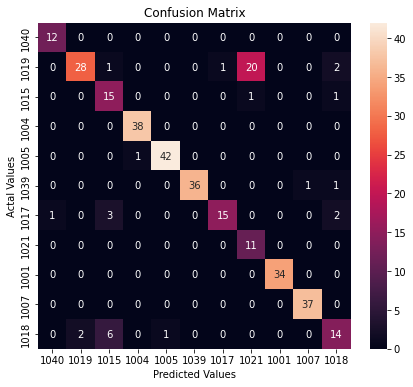

Confusion Matrix : Uncropped


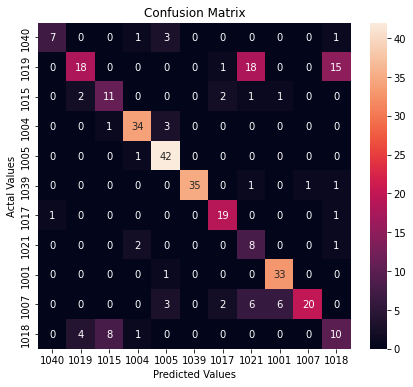

In [ ]:
result(vgg16_model_naug,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr)

> 82.515
> 70.859
Cropped
[ 8  5  1  3  8  3 10  6  6  9  1  5  7  0  4  1  3  5  7 10  0  3  3  2
  4  3  2  9  9  4  0  8  5  2  3  1  1  4  9 10 10  9  5  7  7  9  1  0
  8  8  8  2  7  1 10  0  5  9  2  9  7  8 10  2  7  0  3  4  7  7  3 10
 10  3  5  4  9  9  8  2  2  7  6  2  8  7  2  9  9  8  4  4  4  3  9 10
  3 10  8  9  5  7  8  7  3  4 10  8  4  7  3  2  1  9  9  8  4  1  7  3
  5  8  5  2  3  3  4  8  5  7  7  1  7  6  8  3  2  7 10  6  5  3  8  9
  7  5  7 10  5  4  0  4  9  9  5  1 10  7  5  2  4  4  9  8  4  3 10  5
  9  7  4  3  4  1  3  2  7  8  2  5  4 10  1  6  2  8  7  4  3  0  5  3
  9  4  3  2 10  5  1  9  3  9  7  5  9  5  3  4  1  9  3  0  6  8  5  3
  4  7  4  1  8 10  4  3  8 10 10  0  5  8  6  7  9  3  4  2  4  9  5  4
  2  3  9  4  8  7  8  7  6  6  8  1  8  6  7  2  7  5  3  5  7  4  7  5
 10  4  6  1  5  4  6  6  9  1  9  9  9  1  3  3  4  7  3  6  7  8  2  7
  9  0  5  5  3  0  7  8  4  8  9  9  7  4  8  5  8  9  5  8  8  6  5  3
  2  1  7  1  4  4  4  3 

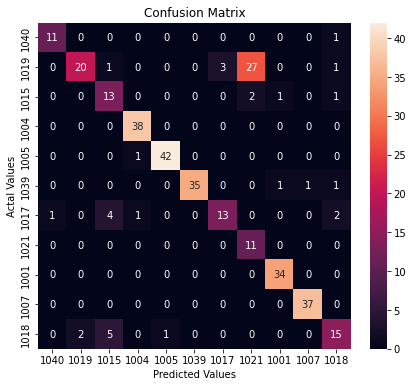

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10] (326,)
[[ 8  0  0  1  3  0  0  0  0  0  0]
 [ 0 14  1  0  0  0  3 20  0  0 14]
 [ 0  0 11  1  0  0  1  4  0  0  0]
 [ 2  0  1 32  2  1  0  0  0  0  0]
 [ 0  0  0  4 37  0  1  0  1  0  0]
 [ 0  0  1  0  0 35  0  0  0  1  1]
 [ 1  0  0  0  0  0 19  1  0  0  0]
 [ 1  0  0  2  0  0  0  8  0  0  0]
 [ 0  0  0  0  1  0  0  0 33  0  0]
 [ 0  0  2  0  3  0  8  0  1 23  0]
 [ 0  4  8  0  0  0  0  0  0  0 11]]


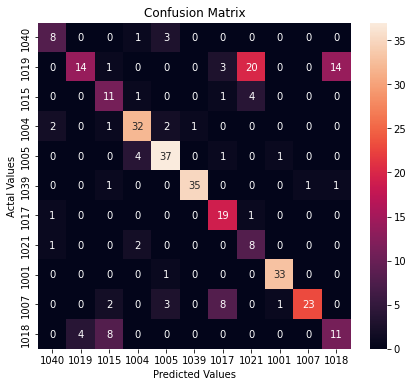

In [ ]:
result(vgg16_model_naug,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr)

# Augmentation


> 90.491
> 74.233
Cropped
[ 8  5  1  3  8  3 10  6  6  9  1  5  7  0  4  1  3  5  7 10  0  3  3  6
  4  3  2  9  9  8  0  5  5  2  3  1  1  4  9 10 10  9  5  1  1  9  1  0
  8  8  8  2  1  1 10  0  5  9  2  9  1  8 10  2  7  0  3  4  7  1  3 10
 10  3  5  3  8  9  8  1  2  1  6  2  8  7  2  9  9  8  4  4  4  3  9  0
  3 10  8  9  5  1  8  7  3  4 10  8  4  1  3  2  1  9  9  8  4  1  1  3
  5  8  5  2  3  3  4  8  5  7  1  1  1  2  8  3  2  1 10  6  5  3  2  9
  7  5  7 10  5  4  0  1  9  9  5  1 10  7  5  6  4  4  9  8  4  3  1  5
  9  1  4  3  4  1  3  2  7  8  2  5  4  1  1  6  2  8  1  4  3  0  5 10
  9  4  3 10 10  5  1  9  3  9  1  5  9  5  3  4  1  9  3  0  1  8  5  3
  4  7  4  1  8 10  4  3  8  1 10  0  5  8  6  6  9  3  4  2  4  9  5  4
  2  3  9  4  8  1  8  1  6  6  8  1  8  6  7  2  1  5  3  5  7  4  7  5
 10  4  6  1  5  4  6  6  9  1  9  9  9  1  3  3  4  7  3  6  1  8  1  1
  9  0  5  5  3  0  1  8  4  8  9  9  7  4  8  5  8  9  5  8  8  1  5  3
 10  1  7  1  4  4  4  3 

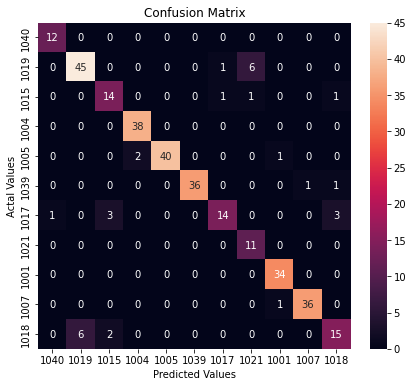

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10] (326,)
[[ 8  0  0  1  3  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  4 14  0  0  3]
 [ 0  0 12  1  0  0  3  1  0  0  0]
 [ 0  2  0 35  1  0  0  0  0  0  0]
 [ 0  1  0  9 33  0  0  0  0  0  0]
 [ 0  0  1  0  0 36  0  1  0  0  0]
 [ 1  0  0  0  0  0 20  0  0  0  0]
 [ 1  0  0  3  0  0  0  7  0  0  0]
 [ 0  0  0  1  1  0  0  0 32  0  0]
 [ 0  0  0  0  3  0  0  1 15 18  0]
 [ 0  6  5  2  0  0  0  0  0  0 10]]


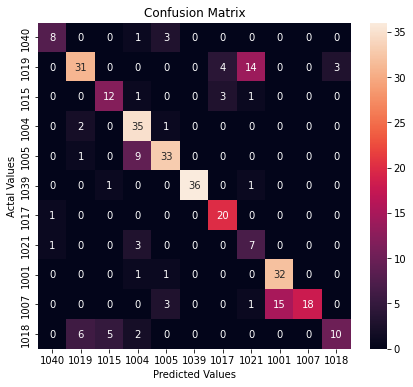

In [ ]:
result(vgg16_model_aug_1,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # default 

> 87.730
> 75.153
Cropped
[ 8  5  1  3  8  3 10  2  6  9  1  5  7  0  4  1  3  5  7 10  0  3  3  2
  4  4  2  9  9  4  0  8  5  2  3  1  1  4  9 10 10  9  5  7  6  9  1  0
  8  8  8  2  1  1 10  0  5  9  2  9  7  8 10  2  7  0  3  4  7  1  3 10
 10  3  5  4  9  9  8  1  2  1  6  2  8  7  2  9  9  8  4  4  4  3  9  0
  3  2  8  9  5 10  8  7  3  4 10  8  4  7  3  2  1  9  9  8  4  1  7  3
  5  8  5  2  3  3  4  8  5  7  1  1  1  6  8  3  2  7  6  6  5  3  2  9
  7  5  7 10  5  4  0 10  9  9  5  1 10  7  5  2  4  4  9  8  4  3 10  5
  9  7  4  3  4  1  3  2  7  8  2  5  4  1  1  1  2  8  1  4  3  0  5  3
  9  4  3 10 10  5  1  9  3  9  7  5  9  5  3  4  1  9  3  0  1  8  5  3
  4  7  4 10  8 10  4  3  8  1  5  0  5  8  6  2  9  3  4  2  4  9  5  4
  2  3  9  4  8  7  8  7  2  6  8  1  8  6  7  2  1  5  3  5  7  4  7  5
 10  4  6  1  5  4  6  6  9  1  9  9  9  1  3  3  4  7  3  6  1  8  1 10
  9  0  5  5  3  0  7  8  4  8  9  9  7  4  8  5  8  9  5  8  8  1  5  3
  2  1  7  1  4  4  4  3 

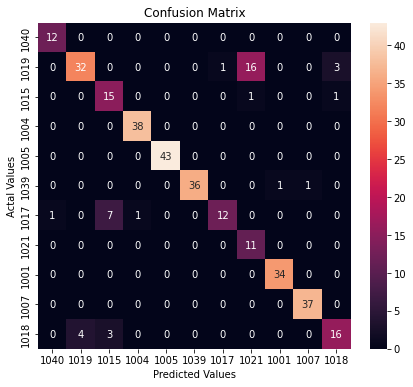

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10] (326,)
[[ 9  0  0  0  3  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  2 16  0  0 16]
 [ 0  0 13  0  0  0  2  1  1  0  0]
 [ 0  1  1 33  3  0  0  0  0  0  0]
 [ 0  1  0  0 42  0  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  1  0]
 [ 1  0  2  0  0  0 13  0  0  0  5]
 [ 0  0  0  2  0  0  0  9  0  0  0]
 [ 0  0  0  0  1  0  0  0 33  0  0]
 [ 0  0  0  0  3  0  0  0  8 26  0]
 [ 0  6  4  1  0  0  0  0  0  0 12]]


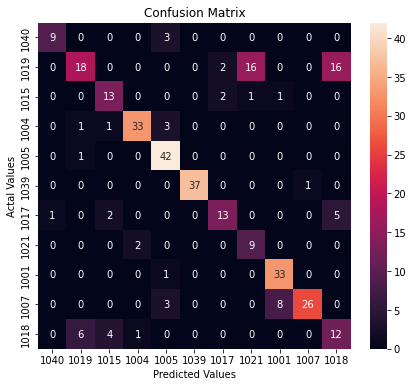

In [ ]:
result(vgg16_model_aug_2,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # only horizontal flip

> 43.865
> 42.025
Cropped
[ 9  5  1  5  9  5  1  2  2  9  1  5  1  9  9  1  2  5  1 10  2  2  5  2
  2  5  2  9  9  9  9  2  5  2  5  1  2  9  9  1  1  9  5  1  1  9  1  2
  5  9  8  2  1  1 10  2  5  9  2  9  1  5  1  2  1  2  5  1  5  1  5  2
  1  1  2  5  9  9  8  2  2  1  2  2  5  1  2  9  9  9  1  1  9  5  9  2
  5  9  9  9  5  1  9  2  5  9  2  9  5  1  5  2  1  9  9  5  6  2  1  5
  5  9  5  2 10  5  1  9  5  5  1  1  1  2  9  5  2  1  9  2  5  5  2  9
  1  5  2  1  5  9  2  1  9  9  5  1  2  5  5  2  9  9  9  5  9  5  2  2
  9  1  2  5  9  1  3  2  1  5  2  5  9  1  1  1  2  9  1  1  5  9  2  2
  9  9  5  1  1  5  1  9  5  9  1  5  9  5  5  5  1  9  5  9  1  9  5  5
  9  9  1  1  9  2  9  5  5  1  5  2  5  9  5  2  9  5  9  2  9  9  2  9
  2  2  9  9  9  1  5  1  2  1  9  1  9  2  1  2  1  5  5  5  2  9  1  5
  1  1  5  1  5  9  2  5  1  1  9  9  9  1  5  2  5  1  5  2  1  9  1  1
  9  9  5  5  5  2  1  5  5  9  9  9  1  9  9  5  9  9  5  9  5  1  5 10
  2  1  1  1  9  9  9  5 

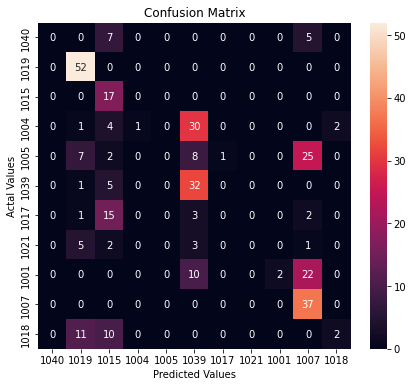

Confusion Matrix : Uncropped
[ 1  2  5  6  7  8  9 10] (326,)
[[ 0  3  6  0  0  0  0  0  0  3  0]
 [ 0 52  0  0  0  0  0  0  0  0  0]
 [ 0  1 16  0  0  0  0  0  0  0  0]
 [ 0 20  1  0  0 17  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  1  0 19  0]
 [ 0  3  9  0  0 24  0  0  0  2  0]
 [ 0  5  9  0  0  0  6  0  0  0  1]
 [ 0  5  1  0  0  0  0  1  0  4  0]
 [ 0  2  5  0  0  4  0  0  1 22  0]
 [ 0  0  0  0  0  0  0  0  0 37  0]
 [ 0 16  7  0  0  0  0  0  0  0  0]]


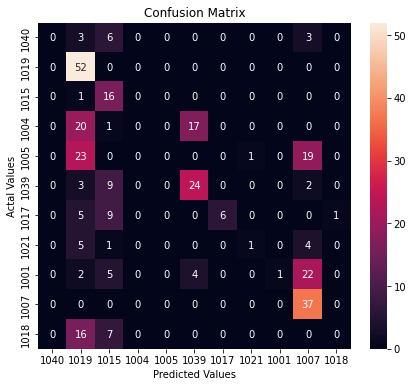

In [ ]:
result(vgg16_model_aug_3,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) # horizontal, horizontal flip, standardization, width and height shift etc

> 87.117
> 76.687
Cropped
[ 8  5  1  3  8  3  1  2  6  9  1  5  1  0  4  1  3  5  7 10  0  3  3  6
  4  4  2  9  9  6  0  8  5  2  3  1  1  4  9 10  1  9  5  1  6  9  1  0
  8  8  8  2  1  1 10  0  5  9  2  9  7  8  1  2  7  0  3  4  7 10  3  2
 10  3  5  4  9  9  8  1  2  1  6  2  8  7  2  9  9  8  4  4  4  3  9  0
  3 10  8  9  5  1  8  7  3  4  2  8  4  1  3  2  1  9  9  8  4  1 10  3
  5  8  5  6  3  3  4  8  5  7  1  1  1  6  8  3  2  7  6  6  5  3  2  9
  7  5  7 10  5  4  6  1  9  9  5  1 10  7  5  2  4  4  9  8  4  3  1  5
  9  1  4  3  4  1  3  2 10  8  2  5  4  1  1  1  2  8  1  4  3  0  5  3
  9  4  3  2  1  5  1  9  3  9 10  5  9  5  3  4  1  9  3  0  1  8  5  3
  4  7  4  1  8 10  4  3  8  1 10  0  5  8  6  6  9  3  4  2  4  9  6  4
  2  3  9  4  8  7  8  1  2  6  8  1  8  6  7  2  1  5  3  5  7  4  7  5
 10  4  6  1  5  4  6  6  9  1  9  9  9  1  3  3  4  7  3  6  1  8  1  1
  9  0  5  5  3  0  4  8  4  8  9  9  7  4  8  5  8  9  5  8  8  1  5  3
  2  1  1  1  4  4  4  3 

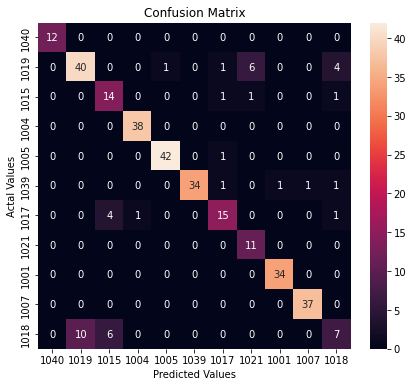

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10] (326,)
[[ 7  0  0  1  4  0  0  0  0  0  0]
 [ 0 30  0  0  0  0 11  8  0  0  3]
 [ 0  0 11  0  0  0  4  1  0  0  1]
 [ 0  2  1 32  3  0  0  0  0  0  0]
 [ 0  0  0  0 43  0  0  0  0  0  0]
 [ 0  0  2  0  0 31  0  1  0  1  3]
 [ 0  0  1  0  0  0 19  0  0  0  1]
 [ 0  0  0  2  0  0  0  7  1  0  1]
 [ 0  0  0  0  5  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  0  2  0 35  0]
 [ 0 10  6  0  1  0  0  0  0  0  6]]


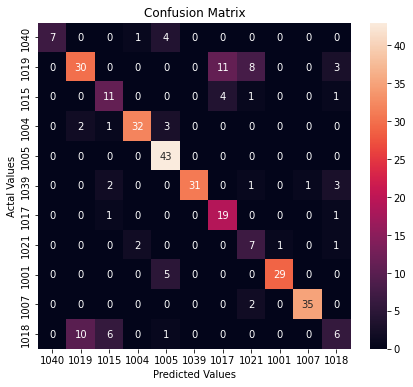

In [ ]:
result(vgg16_model_aug_4,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr) #sheer, zoom, horizontal flip

# Augmentation + Discriminative Learning

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

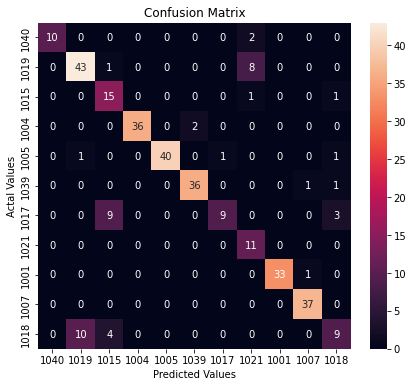

Confusion Matrix : Uncropped
[ 0  1  2  3  4  5  6  7  8  9 10] (326,)
[[ 6  0  0  1  3  0  0  2  0  0  0]
 [ 0 29  0  0  0  0  1 19  0  0  3]
 [ 0  3 12  0  0  0  1  1  0  0  0]
 [ 0  3  0 30  3  0  0  1  0  0  1]
 [ 0  2  0  0 40  0  0  0  0  1  0]
 [ 0  0  1  0  0 35  0  1  0  1  0]
 [ 0  0  2  0  0  0 18  1  0  0  0]
 [ 0  0  0  1  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  0  0  3 34  0]
 [ 0 10  6  0  0  0  0  0  0  0  7]]


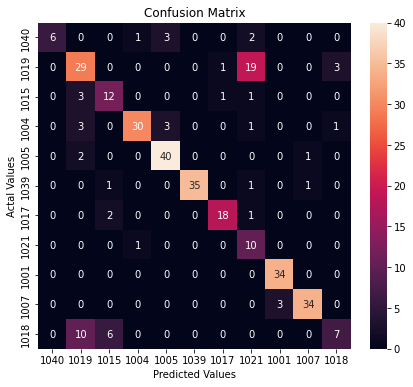

In [ ]:
vgg16_model_dsl = getVGG16Model_disc_learning()
# Augmentation + Discriminative Learning
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 
vgg16_model_dsl.fit(X_train_dg_4.flow(X_train, y_train), epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es]) 

result(vgg16_model_dsl,X_test_cr,X_test_uncr,y_test_cr,y_test_uncr)  # horizontal flip, standardization, width and height shift etc